In [66]:
import pandas as pd
import numpy as np

import requests_cache

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-dark')

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from projectworkflow.data import *

requests_cache.install_cache('project-cache')

In [ ]:
keyfile = '../keys/alpha_vantage'
start_date = '2010-01-01'
key = read_key(keyfile)
market=['SPY'] # SP500 SPDR ETF
sector = ['XLK','XLV'] # IT and HC Sector ETF
industry = ['XBI','XPH','XHS','XHE','XTL','XSD','XWEB','XTH','XSW'] #SPDR ETF's in two sectors XSW try later

spdr_bio_data = get_data(key, industry)
spdr_bio_df = create_df(spdr_bio_data, start_date)

In [68]:
spdr_bio_data.keys()

dict_keys(['XBI', 'XPH', 'XHS', 'XHE', 'XTL'])

XBI is the SPDR ETF for the Biotech Industry, XLV is the SPDR ETF for the Healthcare Sector, SPY is the SPDR ETF for the S&P500. From the general plot of stock movements, we can't really see how the stocks perform relative to each other, as the scale needs to be normalized.

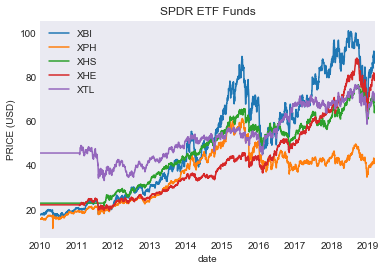

In [20]:
spdr_bio_df.plot()
plt.title('SPDR ETF Funds')
plt.ylabel('PRICE (USD)')
plt.show()

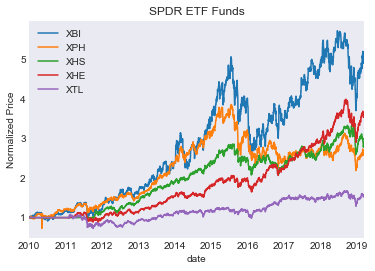

In [21]:
norm_df = spdr_bio_df / spdr_bio_df.iloc[0,:]
norm_df.plot()
plt.title('SPDR ETF Funds')
plt.ylabel('Normalized Price')
plt.show()

Much easier to see that both the Bio and Healtcare ETF's are above the market in general. What's interesting is the volatility seen in the bio fund from 2014 to present day. It begs the question of what other Industry in the Healthcare sector balanced out the volatility. 

In [26]:
investment = 1000000
tlist = [x+1 for x in range(len(industry))]
initial_allocation = [x / np.sum(tlist) for x in tlist]
spdr_bio_port, spdr_bio_port_stats = create_portfolio(spdr_bio_df, investment, initial_allocation)
norm_port = (spdr_bio_port / spdr_bio_port[0]).to_frame().rename({0:'Portfolio'},axis=1)
norm_df = norm_port.merge(norm_df,left_index=True,right_index=True)

In [27]:
spdr_bio_port.to_csv('stocks.csv',header=False)

cumulative returns: 2.542
average daily returns: 0.00041
average daily standard dev: 0.00824
sharpe ratio: 0.065
allocation: [1.06357912e-01 0.00000000e+00 3.38380693e-01 5.55261394e-01
 1.01915004e-17]


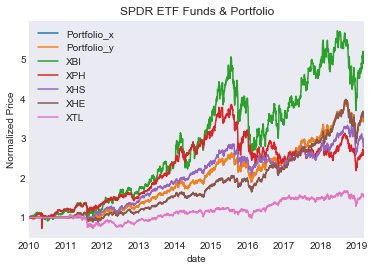

In [28]:
for key,value in spdr_bio_port_stats.items():
    print("{}: {}".format(key,value))
norm_df.plot()
plt.title('SPDR ETF Funds & Portfolio')
plt.ylabel('Normalized Price')
plt.show()

Portfolio returns almost perfectly mirror the Sector ETF. From the below heatmap, i's apparent that the closing prices of our ETF's are all very similar. This can be seen in the weights that the portfolio assigns to optimize the sharpe ratio. While XBI has the largest return of the three, it also appears to be quite volatile.

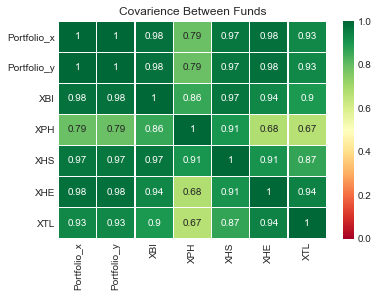

In [29]:
sns.heatmap(norm_df.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)
plt.title('Covarience Between Funds')
plt.show()

Now we train a basic LSTM model through Keras

In [57]:
# feature scaling
train_set = spdr_bio_port.iloc[:-841].values.reshape(-1,1)
test_set = spdr_bio_port.iloc[-841:].values.reshape(-1,1)
print(train_set.shape, test_set.shape)

(2520, 1) (841, 1)


In [64]:
scale = MinMaxScaler(feature_range=(0,1))
train_set_scaled = train_set #scale.fit_transform(train_set)
x_train, y_train = [], []
ts = 15 #timestep -- the size of our initial timestep will be a month

for i in range(ts, train_set.shape[0]):
    x_train.append(train_set_scaled[i-ts:i,0])
    y_train.append(train_set_scaled[i,0])
x_train, y_train = np.asarray(x_train), np.asarray(y_train)    

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


In [59]:
rnn = Sequential()

rnn.add(LSTM(30, input_shape=(x_train.shape[1],1)))
rnn.add(Dense(1))

rnn.compile(optimizer='adam',loss='mean_squared_error')
model = rnn.fit(x_train,y_train, epochs=10, batch_size=20)

Epoch 1/10
2505/2505 [==============================] - 9s 4ms/step - loss: 0.0179
Epoch 2/10
2505/2505 [==============================] - 6s 2ms/step - loss: 3.7273e-04
Epoch 3/10
2505/2505 [==============================] - 6s 2ms/step - loss: 3.3392e-04
Epoch 4/10
2505/2505 [==============================] - 6s 2ms/step - loss: 3.1383e-04
Epoch 5/10
2505/2505 [==============================] - 5s 2ms/step - loss: 3.1481e-04
Epoch 6/10
2505/2505 [==============================] - 6s 2ms/step - loss: 3.2542e-04
Epoch 7/10
2505/2505 [==============================] - 7s 3ms/step - loss: 2.9785e-04
Epoch 8/10
2505/2505 [==============================] - 7s 3ms/step - loss: 3.0457e-04
Epoch 9/10
2505/2505 [==============================] - 7s 3ms/step - loss: 2.9422e-04
Epoch 10/10
2505/2505 [==============================] - 7s 3ms/step - loss: 2.7572e-04


In [61]:
inputs = spdr_bio_port[spdr_bio_port.shape[0] - test_set.shape[0] - ts:].values
inputs = inputs.reshape(-1,1)
inputs = scale.fit_transform(inputs)

x_test = []
for i in range(ts, inputs.shape[0]):
    x_test.append(inputs[i-ts:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_stock_price = rnn.predict(x_test)
predicted_stock_price = scale.inverse_transform(predicted_stock_price)
print(inputs.shape,x_test.shape)

(856, 1) (841, 15, 1)


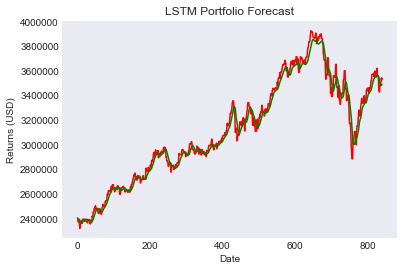

In [62]:
real_stock_price = test_set
plt.plot(real_stock_price, color = 'red', label = 'Real Returns')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Returns')
plt.title('LSTM Portfolio Forecast')
plt.ylabel('Returns (USD)')
plt.xlabel('Date')
plt.show()